<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score, roc_curve

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [41]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [71]:
data = pd.read_csv('./train (1).csv')
data_test = pd.read_csv('./test.csv')
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


**Посмотрим на пропуски**

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [73]:
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [74]:
data = data.replace(' ', np.nan)
#data = data.dropna()
data = data.fillna(0)

In [76]:
data_test = data_test.replace(' ', np.nan)
#data_test = data_test.dropna()
data_test = data_test.fillna(0)

**Вывод - на самом деле пропуски есть в колонке Total spent**

In [77]:
data["TotalSpent"] = pd.to_numeric(data["TotalSpent"])
data_test["TotalSpent"] = pd.to_numeric(data_test["TotalSpent"])

In [78]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

In [13]:
import seaborn as sns

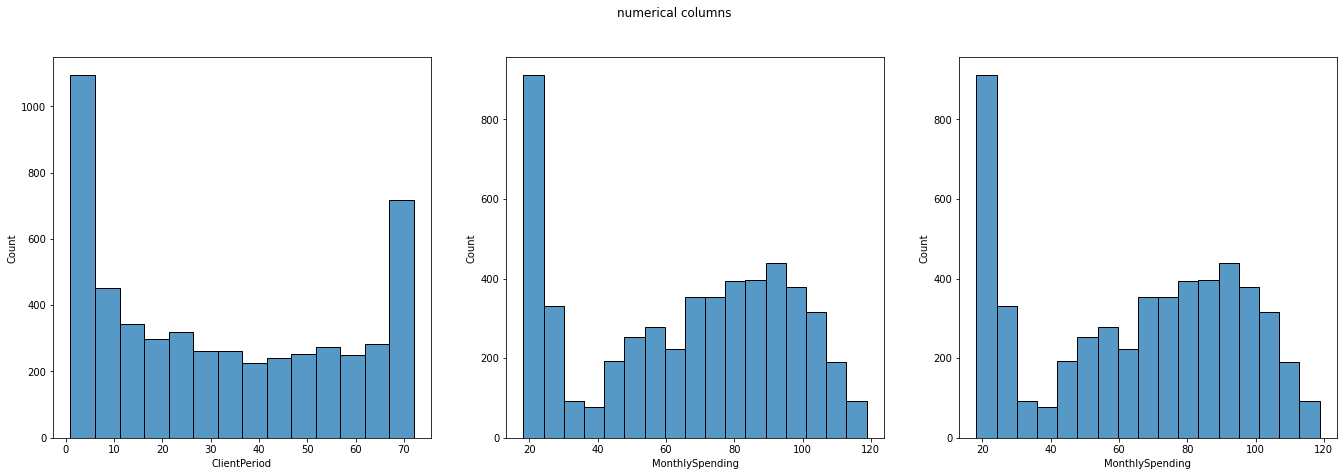

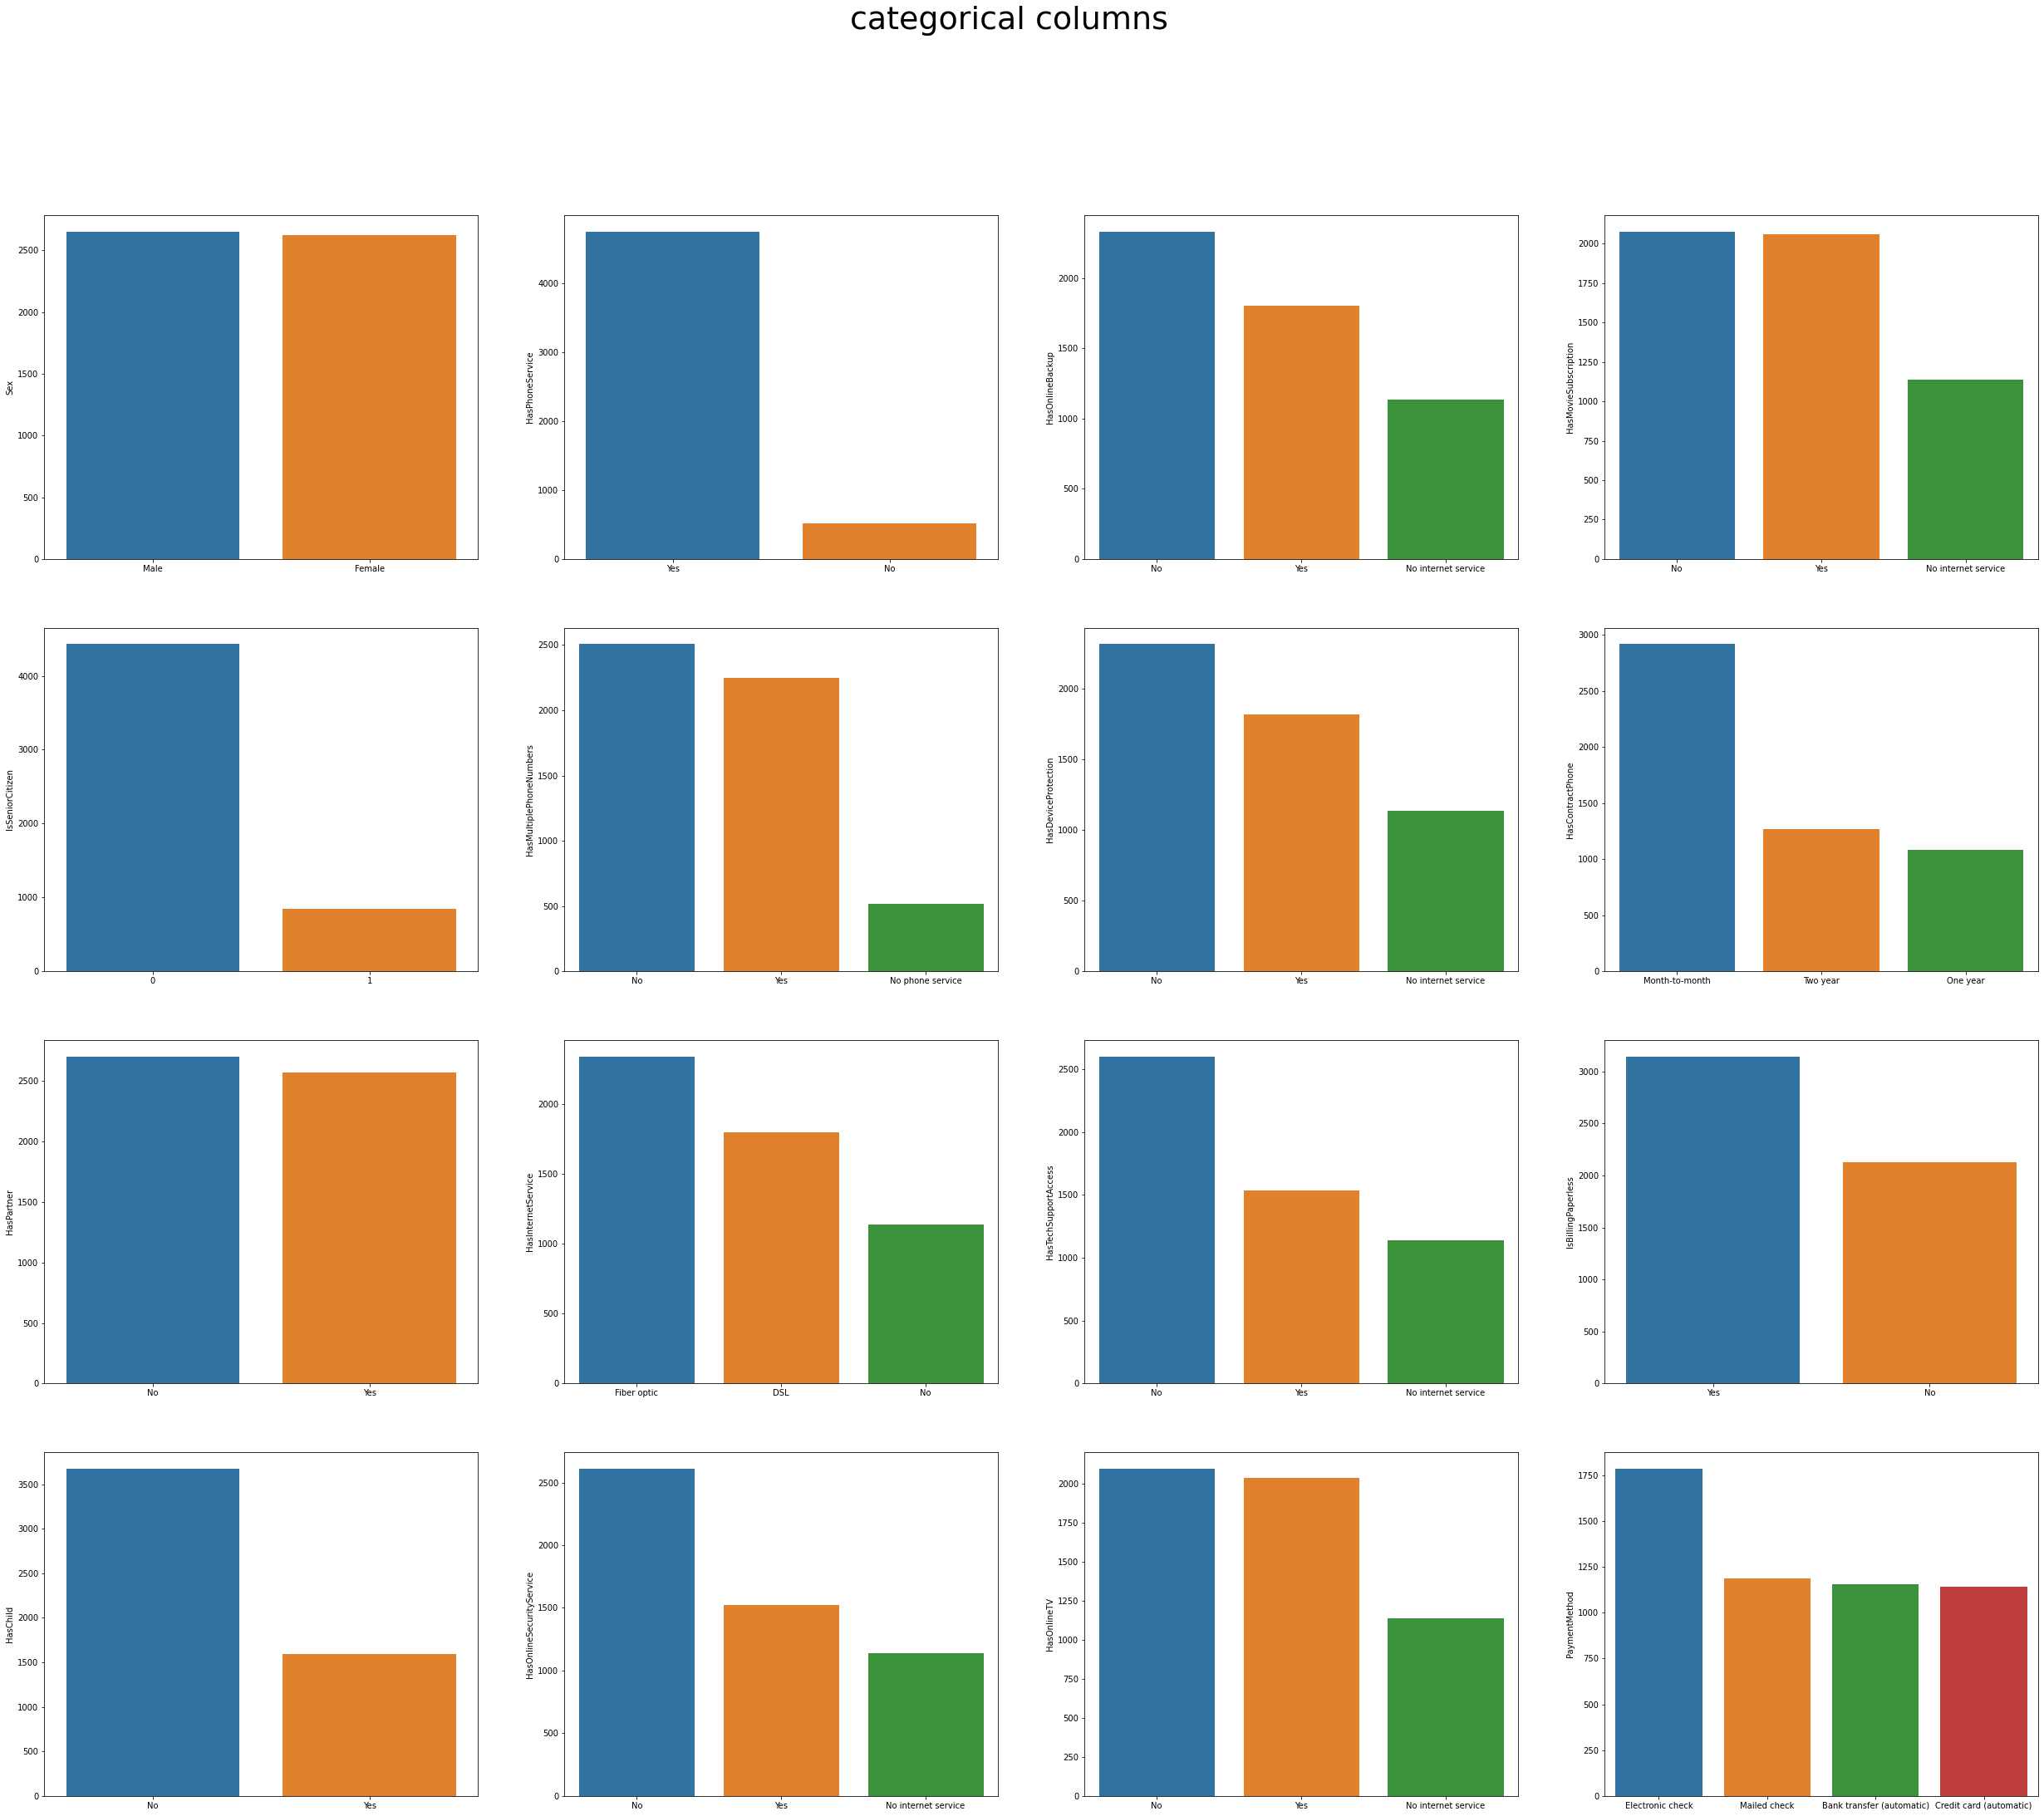

In [53]:
import seaborn as sns
%matplotlib inline
fig, axs = plt.subplots(1, 3, figsize = (23, 7))
sns.histplot(data, x = 'ClientPeriod', ax = axs[0])
sns.histplot(data, x = 'MonthlySpending', ax = axs[1])
sns.histplot(data, x = 'MonthlySpending', ax = axs[2])
fig.suptitle('numerical columns')
plt.show()

def categorical_meanings(X):
    return data[X].value_counts()

fig, axs = plt.subplots(4, 4, figsize = (43, 35))
fig.suptitle('categorical columns', size = 38)
for ind, name in enumerate(cat_cols):
    aa = categorical_meanings(name) 
    sns.barplot(x = aa.index, y = aa, ax = axs[ind - 4 * (ind // 4), ind // 4])

In [54]:
for category in cat_cols:
  print(category, 'разновидности признаков: ', data[category].unique(), ' количество признаков: ', len(data[category].unique())) 

Sex разновидности признаков:  ['Male' 'Female']  количество признаков:  2
IsSeniorCitizen разновидности признаков:  [0 1]  количество признаков:  2
HasPartner разновидности признаков:  ['Yes' 'No']  количество признаков:  2
HasChild разновидности признаков:  ['Yes' 'No']  количество признаков:  2
HasPhoneService разновидности признаков:  ['Yes' 'No']  количество признаков:  2
HasMultiplePhoneNumbers разновидности признаков:  ['No' 'Yes' 'No phone service']  количество признаков:  3
HasInternetService разновидности признаков:  ['No' 'Fiber optic' 'DSL']  количество признаков:  3
HasOnlineSecurityService разновидности признаков:  ['No internet service' 'No' 'Yes']  количество признаков:  3
HasOnlineBackup разновидности признаков:  ['No internet service' 'No' 'Yes']  количество признаков:  3
HasDeviceProtection разновидности признаков:  ['No internet service' 'No' 'Yes']  количество признаков:  3
HasTechSupportAccess разновидности признаков:  ['No internet service' 'Yes' 'No']  количество

**Корреляция**

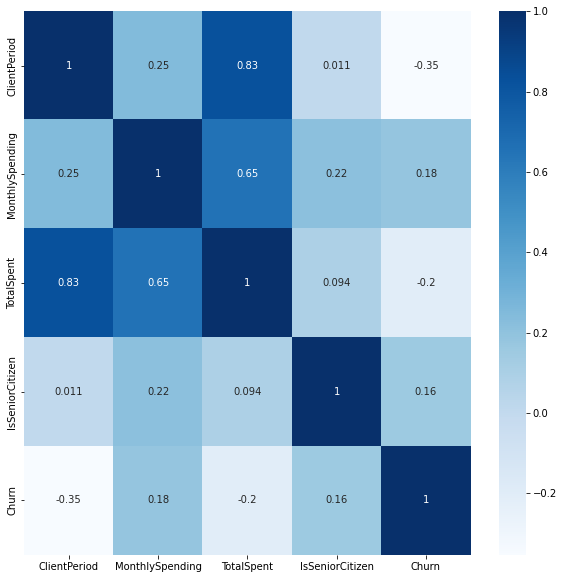

In [55]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),cbar=True,annot=True,cmap='Blues')

**Распределение целевой переменной**

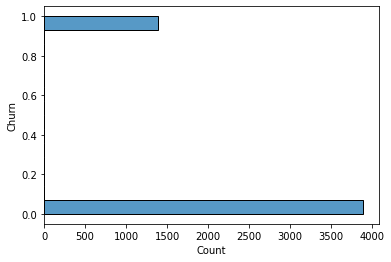

In [56]:
sns.histplot(data, y='Churn')

**Следовательно данные распределены не совсем ранвномерно. Класса 0 намного больше, чем класса 1**

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [79]:
for num in feature_cols:
  print(num, '-----', data[num].dtype)

ClientPeriod ----- int64
MonthlySpending ----- float64
TotalSpent ----- float64
Sex ----- object
IsSeniorCitizen ----- int64
HasPartner ----- object
HasChild ----- object
HasPhoneService ----- object
HasMultiplePhoneNumbers ----- object
HasInternetService ----- object
HasOnlineSecurityService ----- object
HasOnlineBackup ----- object
HasDeviceProtection ----- object
HasTechSupportAccess ----- object
HasOnlineTV ----- object
HasMovieSubscription ----- object
HasContractPhone ----- object
IsBillingPaperless ----- object
PaymentMethod ----- object


###One hot encoding

In [80]:
numeric_data = data[num_cols]
categorial_data = data[cat_cols]
categorial_data

,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check
1,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
2,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check
3,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check
4,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,Male,0,No,No,No,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,No,Electronic check
5278,Male,0,Yes,No,No,No phone service,DSL,Yes,No,No,Yes,Yes,No,One year,Yes,Bank transfer (automatic)
5279,Male,0,No,No,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Mailed check
5280,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic)


In [81]:
numeric_data_test = data_test[num_cols]
categorial_data_test = data_test[cat_cols]

In [82]:
dummy_features = pd.get_dummies(categorial_data)
X = pd.concat([numeric_data, dummy_features], axis=1)
X_origin = data.iloc[:, :-1]
X.head()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Sex_Female,Sex_Male,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,HasPhoneService_No,HasPhoneService_Yes,HasMultiplePhoneNumbers_No,HasMultiplePhoneNumbers_No phone service,HasMultiplePhoneNumbers_Yes,HasInternetService_DSL,HasInternetService_Fiber optic,HasInternetService_No,HasOnlineSecurityService_No,HasOnlineSecurityService_No internet service,HasOnlineSecurityService_Yes,HasOnlineBackup_No,HasOnlineBackup_No internet service,HasOnlineBackup_Yes,HasDeviceProtection_No,HasDeviceProtection_No internet service,HasDeviceProtection_Yes,HasTechSupportAccess_No,HasTechSupportAccess_No internet service,HasTechSupportAccess_Yes,HasOnlineTV_No,HasOnlineTV_No internet service,HasOnlineTV_Yes,HasMovieSubscription_No,HasMovieSubscription_No internet service,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,55,19.50,1026.35,0,0,1,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1
1,72,25.85,1872.20,0,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0
2,1,75.90,75.90,0,0,1,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
3,32,79.30,2570.00,1,1,0,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1
4,60,115.25,6758.45,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0


In [83]:
dummy_features_test= pd.get_dummies(categorial_data_test)
X_for_test = pd.concat([numeric_data_test, dummy_features_test], axis=1)
X_for_test.head()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Sex_Female,Sex_Male,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,HasPhoneService_No,HasPhoneService_Yes,HasMultiplePhoneNumbers_No,HasMultiplePhoneNumbers_No phone service,HasMultiplePhoneNumbers_Yes,HasInternetService_DSL,HasInternetService_Fiber optic,HasInternetService_No,HasOnlineSecurityService_No,HasOnlineSecurityService_No internet service,HasOnlineSecurityService_Yes,HasOnlineBackup_No,HasOnlineBackup_No internet service,HasOnlineBackup_Yes,HasDeviceProtection_No,HasDeviceProtection_No internet service,HasDeviceProtection_Yes,HasTechSupportAccess_No,HasTechSupportAccess_No internet service,HasTechSupportAccess_Yes,HasOnlineTV_No,HasOnlineTV_No internet service,HasOnlineTV_Yes,HasMovieSubscription_No,HasMovieSubscription_No internet service,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,42,56.10,2386.85,0,0,1,0,1,1,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0
1,29,98.50,3004.15,1,0,1,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0
2,9,76.25,684.85,0,0,1,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
3,67,74.00,4868.40,0,1,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0
4,71,20.10,1389.60,0,1,0,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0


In [84]:
y = data['Churn']
y

0       0
1       0
2       1
3       0
4       0
       ..
5277    0
5278    0
5279    0
5280    0
5281    0
Name: Churn, Length: 5282, dtype: int64

###Разделение на train и test

In [85]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    train_size=0.8,
                                                    random_state=42)

In [87]:
X_train

array([[3.10000e+01, 7.35500e+01, 2.09465e+03, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [5.90000e+01, 1.00050e+02, 6.03485e+03, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       [6.00000e+01, 9.90000e+01, 6.01790e+03, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00],
       ...,
       [5.00000e+01, 2.05500e+01, 1.07025e+03, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [8.00000e+00, 8.45000e+01, 6.62650e+02, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [6.80000e+01, 5.44500e+01, 3.67495e+03, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00]])

###Отнормируем числовые признаки

In [88]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Отнормируем числовые признаки на тестовой выборке**

In [89]:
scaler_test = StandardScaler()
X_for_test = scaler.transform(X_for_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


**Начинаем пробовать модели**

In [65]:
def search_and_draw(X, y, model, param_name, grid, param_scale='ordinary', draw=True):
    #param_scale - какую шкалу рисовать? обычную или логарифмическую

    parameters = {param_name: grid}                  #{название параметра: какие значения могут принимать}
    
    CV_model = GridSearchCV(estimator=model,         #какую модель подбираем (линейная регрессия, knn...)
                            param_grid=parameters,   #наша сетка с параметрами
                            cv=5,                    #количество фолдов в кросс валидации
                            scoring='f1',            #метрика, f1 - хорошая метрика для бинарной классификации (чем p ближе к 1, тем лучше)
                            n_jobs=-1,               #паралелльное вычисление фолдов
                            verbose=10)              #насколько часто нужно писать логирование (информацию)
    CV_model.fit(X, y)
    means = CV_model.cv_results_['mean_test_score']
    error = CV_model.cv_results_['std_test_score']
    
    if draw:
        plt.figure(figsize=(15,8))
        plt.title('choose ' + param_name)


        if (param_scale == 'log'):
            plt.xscale('log')

        plt.plot(grid, means, label='mean values of score', color='red', lw=3)

        plt.fill_between(grid, means - 2 * error, means + 2 * error, 
                         color='green', label='filled area between errors', alpha=0.5)
        legend_box = plt.legend(framealpha=1).get_frame()
        legend_box.set_facecolor("white")
        legend_box.set_edgecolor("black")
        plt.xlabel('parameter')
        plt.ylabel('roc_auc')
        plt.show()
        
    return means, error

###Логистическая регрессия

In [90]:
model = LogisticRegression()
parameters = {'C': [100, 10, 1, 0.1, 0.01, 0.001]}
CV_model = GridSearchCV(estimator=model,         
                        param_grid=parameters,   
                        cv=5,                    #количество фолдов в кросс валидации
                        scoring='roc_auc',            
                        n_jobs=-1,   
                        refit=True) 
CV_model.fit(X_train, y_train)
print(CV_model.best_params_)

{'C': 0.1}


In [91]:
roc_auc_score(y_test, CV_model.predict_proba(X_test)[:, 1])

0.8272226891144338

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

**По метрике roc_auc_score на тестовой выборке мне получилось добиться качества 84,2%. Наилучший гиперпараметр C = 1**




## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

###Градиетный бустинг с помощью catboost

In [75]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 46 kB/s 


In [76]:
import catboost

In [77]:
X_train_origin, X_test_origin, _, _ = train_test_split(X_origin.values, y.values, 
                                                       train_size=0.8, 
                                                       random_state=42)

In [92]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, cat_features=cat_cols)
boosting_model.fit(X_train_origin, y_train)

# y_train_predicted = boosting_model.predict_proba(X_train_origin)[:, 1]
# y_test_predicted = boosting_model.predict_proba(X_test_origin)[:, 1]

CatBoostError: ignored

In [ ]:
roc_auc_score(y_test, boosting_model.predict_proba(X_test)[:, 1])

###Градиентный бустинг с помощью xgboost

In [92]:
import xgboost

In [93]:
boosting_model = xgboost.XGBClassifier(n_estimators=300, learning_rate=0.02)

boosting_model.fit(X_train, y_train)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]

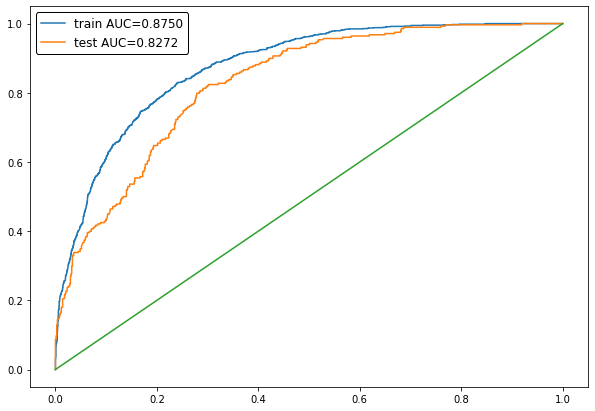

In [94]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [95]:
roc_auc_score(y_test, boosting_model.predict_proba(X_test)[:, 1])

0.827218071499155

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

**первая попытка на Kaggle (logistic regression - 80%)**

**вторая попытка на Kaggle (xgboost - 82%)**

# Предсказания

In [101]:
from google.colab import files

In [103]:
best_model = boosting_model

In [102]:
submission = pd.read_csv('./submission.csv')
y_test_predicted = best_model.predict_proba(X_for_test)[:, 1]
submission[target_col] = y_test_predicted
submission.to_csv('submission_regression.csv',index=False)
files.download("submission_regression.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [104]:
y_test_predicted = best_model.predict_proba(X_for_test)[:, 1]
submission[target_col] = y_test_predicted
submission.to_csv('submission_xgboost.csv',index=False)
files.download("submission_xgboost.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.